In [21]:
import torch
from torchvision.datasets import FashionMNIST

# Fashion MNIST 데이터셋 불러오기
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [22]:
train_input = fm_train.data
train_target = fm_train.targets

In [23]:
# 정규화 (0~1)
train_scaled = train_input / 255.0

In [24]:
from sklearn.model_selection import train_test_split

# 훈련/검증 세트 분리
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

참고) `test_size`에 실수(0~1) 넣으면 비율, 정수 넣으면 개수

In [25]:
import torch.nn as nn

# 모델을 위한 층 구성 - 파이토치에는 함수가 따로 존재 (Sequential)

model = nn.Sequential(
    nn.Flatten(),           # 입력 이미지 펼침 (2D (28, 28) -> 1D (28 * 28))
    nn.Linear(28*28, 100),  # 입력층(784) -> 은닉층(유닛100) / Linear: 선형회귀
    nn.ReLU(),              # 비선형 활성화 함수 (ReLU)
    nn.Dropout(0.3),        # 과적합 방지용 드롭아웃 (30% 비활성화)
    nn.Linear(100, 10)      # 은닉층(유닛100) -> 출력층(클래스10)
                            # 참고: 손실함수 쪽(nn.CrossEntropyLoss())에 내부적으로 softmax 포함
)

In [26]:
# GPU, CPU 결정 후 모델에 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 맥: device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [27]:
import torch.optim as optim

# loss function, optimizer 설정
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # lr: learning rate (기본값 - 0.01)

참고) learning rate는 0.001로 고정이 아니라, 매 에포크마다 조정된다.

In [ ]:
# 모델 훈련 - 콜백, 조기 종료를 위한 함수가 파이토치에는 없다. 직접 해야 함.

# 필요한 변수 선언
train_history = []  # 훈련 세트의 각 에포크마다의 loss값을 저장할 리스트
val_history = []    # 검증 세트의 각 에포크마다의 loss값을 저장할 리스트
patience = 3        # loss값이 상승해도 눈 감아줄 횟수
best_loss = 2       # 가장 낮은 loss값 저장 (기본값을 2로 설정, 어차피 loss는 0~1이기 때문)
early_stopping_counter = 0   # 조기 종료 카운트 (patience에 도달하면 조기 종료)
epochs = 50         # 훈련 반복 횟수: 50번
batches = int(len(train_scaled) / 32)  # 미니 배치 학습 반복 횟수 per 1 epoch (32개씩 반복)

# 훈련
for epoch in range(epochs):
    ###### 훈련 ######

    model.train()   # 훈련 시작

    train_loss = 0  # 훈련 세트 평균 loss per 1 epoch
    for i in range(batches):  # 미니배치 경사 하강법 (32개씩 1500번 반복)
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)

        optimizer.zero_grad()    # Gradient 연산 초기화
        outputs = model(inputs)  # 예측값 추론

        loss = criterion(outputs, targets)  # 손실값(loss)
        loss.backward()  # 역전파
        optimizer.step() # 모델 파라미터 업데이트

        train_loss += loss.item()  # 미니 배치 학습 때마다의 loss를 누적 (총 1500번 per 1 epoch)

    ###### 검증 ######

    model.eval()  # epoch마다 검증 세트를 가지고 훈련된 모델 평가 진행

    val_loss = 0  # 검증 세트의 loss
    with torch.no_grad():  # 평가이므로 Gradient 연산(학습)은 하지 않는다
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        outputs = model(val_scaled)  # 검증 세트의 예측값
        loss = criterion(outputs, val_target)  # 검증 세트의 손실값(loss)
        val_loss = loss.item()

    # 훈련/검증 세트의 loss를 기록 per 1 epoch
    train_loss_avg = train_loss / batches
    train_history.append(train_loss_avg)  # 1 epoch 당 훈련 세트 손실값 평균
    val_history.append(val_loss)          # 1 epoch 당 검증 세트 손실값

    print(f"epochs: {epoch + 1}, loss: {train_loss_avg:.4f}, val_loss: {val_loss:.4f}")

    # 현재 에포크의 검증 손실이 기존 검증 손실보다 작은 경우 - 더 좋은 것이므로 손실값 업데이트
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0  # 조기 종료 카운트를 초기화
        torch.save(model.state_dict(), "best_model.pth")  # 모델의 가중치만 저장
        # 파이토치는 keras와 다르게 전체 모델을 저장할 일은 없다. 매번 모델 재구성해서 복구해야 함.
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 
        :
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break  # 반복 종료

epochs: 1, loss: 0.6032, val_loss: 0.4384
epochs: 2, loss: 0.4448, val_loss: 0.3901
epochs: 3, loss: 0.4034, val_loss: 0.3788
epochs: 4, loss: 0.3847, val_loss: 0.3600
epochs: 5, loss: 0.3645, val_loss: 0.3483
epochs: 6, loss: 0.3551, val_loss: 0.3435
epochs: 7, loss: 0.3417, val_loss: 0.3471
epochs: 8, loss: 0.3350, val_loss: 0.3374
epochs: 9, loss: 0.3288, val_loss: 0.3355
epochs: 10, loss: 0.3201, val_loss: 0.3244
epochs: 11, loss: 0.3149, val_loss: 0.3321
epochs: 12, loss: 0.3096, val_loss: 0.3296
epochs: 13, loss: 0.3034, val_loss: 0.3281
13번째 에포크에서 조기 종료되었습니다.


🔍 PyTorch는 왜 가중치만 저장하나?
1. 모델 구조 = 코드
    - PyTorch는 모델 정의 자체가 Python 클래스임 → 구조를 저장할 필요가 없음.
    - 다시 쓸 때 그냥 같은 클래스를 재정의하면 됨.

2. 직렬화 문제
    - PyTorch의 전체 모델 저장 (torch.save(model))은 가능하긴 하지만, 내부적으로 Pickle을 사용\
    → 버전 의존성, 보안 이슈 존재
    - 따라서 실무에서는 가중치만 저장/로드하는 방식이 훨씬 안전하고 보편적임.

✨ Keras는 왜 전체 저장이 많을까?

- Keras는 모델 구조 자체가 JSON/Config 형태로 직렬화 가능 → 전체 저장이 쉬움
- model.save('model.keras') 한 줄이면 구조 + 가중치 + 옵티마이저까지 저장됨

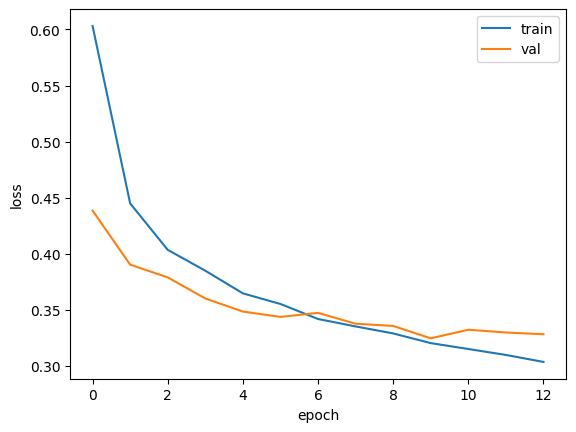

In [29]:
import matplotlib.pyplot as plt

# 검증 세트의 loss 경향성 그래프 그리기
plt.plot(train_history, label='train') # 훈련 세트의 loss
plt.plot(val_history, label='val')     # 검증 세트의 loss

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

In [30]:
# 저장된 모델의 가중치를 로드
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [31]:
model.eval()
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    loss = criterion(outputs, val_target)
    predicts = torch.argmax(outputs, 1)
    # print(predicts[:10])
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"val_accuracy: {accuracy:.4f}, val_loss: {loss.item():.4f}")

val_accuracy: 0.8828, val_loss: 0.3244
